By: Nasrullah, nasrullah.devs@gmail.com

Implement 5 Model:
- [ARIMA](#ARIMA)
- [Auto-ARIMA](#Auto-ARIMA)
- [LSTM](#LSTM)
- [Multivariate](#Multivariate)
- [Prophet](#Prophet)

# Import Library

In [283]:
import numpy as np
import pandas as pd
import warnings

# EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import pickle
import prophet
import tensorflow as tf

C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



### Config

In [213]:
class Config:
    target = 'Close'
    forecasting_days = 100

## Model

In [214]:
os.makedirs('model', exist_ok=True)

# Read Data

In [215]:
df = pd.read_csv('data/brentcrudeoil-dailybrentoil.csv', index_col='Date', parse_dates=['Date'])
df.index = df.index.date
df.head()

,Close,chg(close),Low,chg(low),High,chg(high)
2021-01-04,50.23,50.23,49.97,49.97,51.88,51.88
2021-01-05,51.87,1.64,50.01,0.04,52.26,0.38
2021-01-06,52.02,0.15,51.21,1.20,52.37,0.11
2021-01-07,52.20,0.18,51.89,0.68,52.34,-0.03
2021-01-08,53.33,1.13,52.31,0.42,53.61,1.27


Create `Open` feature

In [216]:
# Create Open feature
new_cols = [ 'Open', 'Close', 'chg(close)', 'Low', 'chg(low)', 'High', 'chg(high)']

df['Open'] = df.shift(1).Close
df = df.reindex(columns=new_cols)

# Remove NaN row data
df.dropna(inplace=True)
df.head()

,Open,Close,chg(close),Low,chg(low),High,chg(high)
2021-01-05,50.23,51.87,1.64,50.01,0.04,52.26,0.38
2021-01-06,51.87,52.02,0.15,51.21,1.20,52.37,0.11
2021-01-07,52.02,52.20,0.18,51.89,0.68,52.34,-0.03
2021-01-08,52.20,53.33,1.13,52.31,0.42,53.61,1.27
2021-01-11,53.33,53.33,0.00,52.66,0.35,53.48,-0.13


### Correlation

In [217]:
df.corr()

,Open,Close,chg(close),Low,chg(low),High,chg(high)
Open,1.000000,0.986501,-0.105491,0.992256,-0.050178,0.993346,-0.031401
Close,0.986501,1.000000,0.058776,0.995957,0.059382,0.994396,0.061759
chg(close),-0.105491,0.058776,1.000000,-0.000855,0.666489,-0.016984,0.566455
Low,0.992256,0.995957,-0.000855,1.000000,0.049869,0.995342,0.035796
chg(low),-0.050178,0.059382,0.666489,0.049869,1.000000,0.014216,0.668036
High,0.993346,0.994396,-0.016984,0.995342,0.014216,1.000000,0.049284
chg(high),-0.031401,0.061759,0.566455,0.035796,0.668036,0.049284,1.000000


In [218]:
df.corr()[['Close']].sort_values('Close', ascending=False)

,Close
Close,1.000000
Low,0.995957
High,0.994396
Open,0.986501
chg(high),0.061759
chg(low),0.059382
chg(close),0.058776


In [219]:
# drop low correlation
df.drop(columns=['chg(high)', 'chg(close)', 'chg(low)'], inplace=True)
df.head()

,Open,Close,Low,High
2021-01-05,50.23,51.87,50.01,52.26
2021-01-06,51.87,52.02,51.21,52.37
2021-01-07,52.02,52.20,51.89,52.34
2021-01-08,52.20,53.33,52.31,53.61
2021-01-11,53.33,53.33,52.66,53.48


### Split Data

In [220]:
def cut_data(df, y, num_start, num_end):
    df2 = df[num_start:(num_end+1)]
    y2 = y[num_start:(num_end+1)] if y is not None else None
    return df2, y2


In [221]:
timesteps = df.index.to_numpy()
prices = df['Close'].to_numpy()

timesteps[:5], prices[:5]

(array([datetime.date(2021, 1, 5), datetime.date(2021, 1, 6),
        datetime.date(2021, 1, 7), datetime.date(2021, 1, 8),
        datetime.date(2021, 1, 11)], dtype=object),
 array([51.87, 52.02, 52.2 , 53.33, 53.33]))

In [222]:
split_size = int(0.8 * len(prices))

X_train , y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]


len(X_train), len(X_test), len(y_train), len(y_test)

(606, 152, 606, 152)

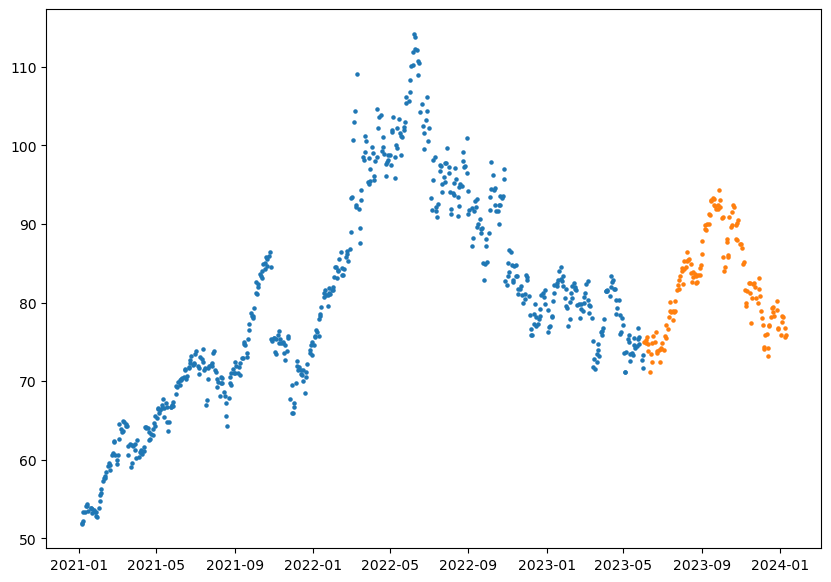

In [223]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.show()

In [224]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("NYMEX Price")
    
    if label:
        plt.legend(fontsize=14)
        
    plt.grid(True)

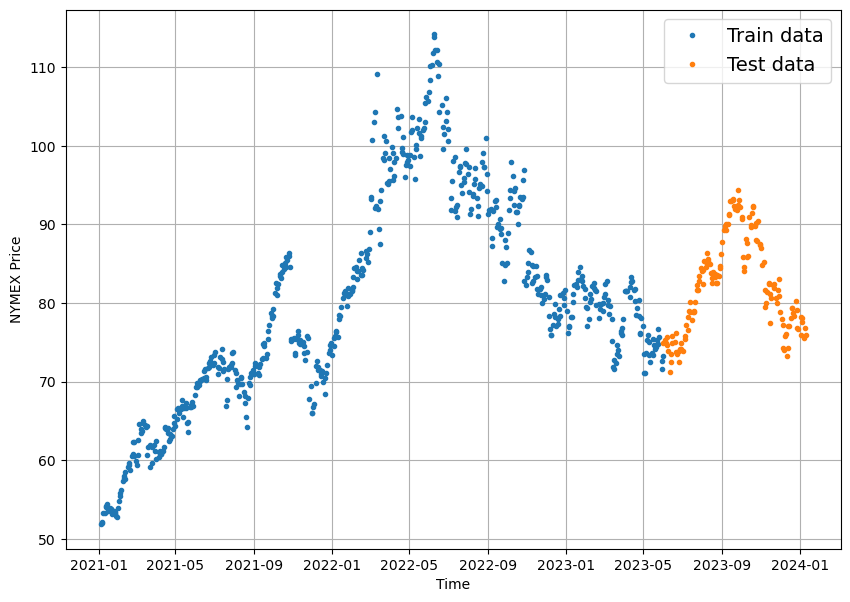

In [226]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

### Windowing dataset

Windowing for one week<br>
features -> labels<br>
[0, 1, 2, 3, 4, 5, 6] -> [7]<br>
[1, 2, 3, 4, 5, 6, 7] -> [8]

In [227]:
print(f"We want to use: {prices[:7]} to predict this: {prices[7]}")

We want to use: [51.87 52.02 52.2  53.33 53.33 54.12 54.13] to predict this: 54.43


In [228]:
HORIZON = 1
WINDOW_SIZE = 7

In [229]:
def get_labeled_windows(x, horizon):
    return x[:, :-horizon], x[:, -horizon:]

In [230]:
# test label function
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8) + 1, axis=0), 1)
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]])>)

In [231]:
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [232]:
# Create a function to view NumPy arrays as windows
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon-1)), axis=0).T # create 2D array of windows 
    windowed_array = x[window_indexes]
    windows, labels = get_labeled_windows(windowed_array, horizon=HORIZON)

    return windows, labels


In [233]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(751, 751)

In [234]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [51.87 52.02 52.2  53.33 53.33 54.12 54.13] -> Horizon: [54.43]
Window: [52.02 52.2  53.33 53.33 54.12 54.13 54.43] -> Horizon: [53.53]
Window: [52.2  53.33 53.33 54.12 54.13 54.43 53.53] -> Horizon: [53.89]


In [235]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Horizon: {full_labels[i-3]}")

Window: [79.09 76.82 76.64 75.89 78.25 77.59 78.14] -> Horizon: [75.6]
Window: [76.82 76.64 75.89 78.25 77.59 78.14 75.6 ] -> Horizon: [76.81]
Window: [76.64 75.89 78.25 77.59 78.14 75.6  76.81] -> Horizon: [75.89]


In [236]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int((1 - test_split) * len(windows))
    X_train, y_train = windows[:split_size], labels[:split_size]
    X_test, y_test = windows[split_size:], labels[split_size:]

    return X_train, X_test, y_train, y_test


In [237]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(600, 151, 600, 151)

In [238]:
train_windows[:5], train_labels[:5]

(array([[51.87, 52.02, 52.2 , 53.33, 53.33, 54.12, 54.13],
        [52.02, 52.2 , 53.33, 53.33, 54.12, 54.13, 54.43],
        [52.2 , 53.33, 53.33, 54.12, 54.13, 54.43, 53.53],
        [53.33, 53.33, 54.12, 54.13, 54.43, 53.53, 53.89],
        [53.33, 54.12, 54.13, 54.43, 53.53, 53.89, 53.82]]),
 array([[54.43],
        [53.53],
        [53.89],
        [53.82],
        [53.79]]))

# EDA

## Close data

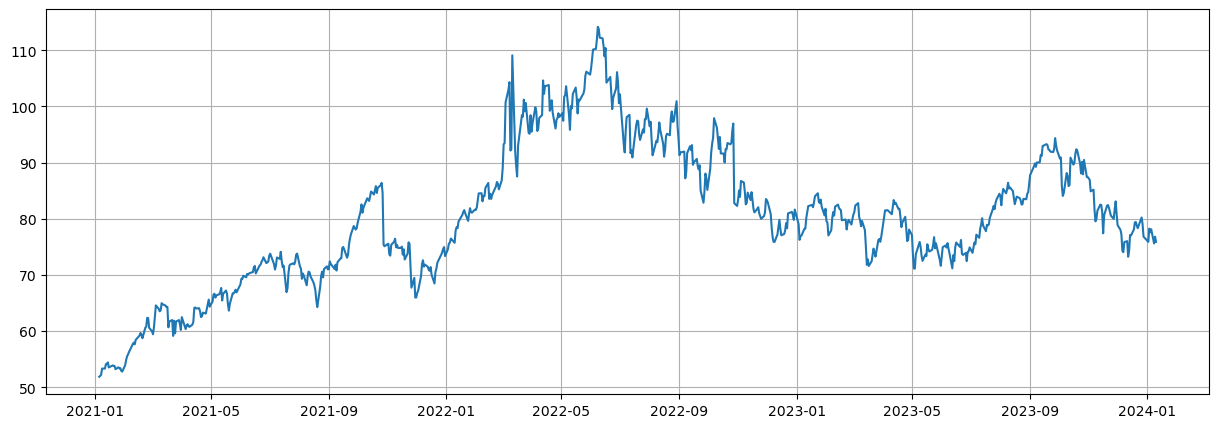

In [239]:
df.Close.plot(grid=True, figsize=(15, 5))

In [240]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x=data.index,
                                                   open = data['Open'], 
                                                   high = data['High'], 
                                                   low = data['Low'], 
                                                   close = data['Close'])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
            'text': '{:} Candelstick Chart'.format(label),
            'y':0.8,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

In [241]:
oil_candle = c_chart(df, label=Config.target)
oil_candle.show()

## Stationarity Check

In [242]:
def stationarity_checker(time_series, dropna=True):
    if dropna:
        time_series = time_series.dropna()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df_adf = _adf_test(time_series)
        df_kpss = _kpss_test(time_series)

    df = pd.concat([df_adf, df_kpss], axis=1, sort=False).T
    _adf, _kpss = df.reject_null = df.reject_null.astype(bool)

    if _adf:
        print('ADF:        Series is stationary')
    else:
        print('ADF:        Series is non-stationary')

    if _kpss:
        print('KPSS:       Series is non-stationary')
    else:
        print('KPSS:       Series is trend stationary')

    if _adf and _kpss:
        print('Conclusion: Series may be difference stationary. Try using differencing.')
    elif (not _adf) and _kpss:
        print('Conclusion: Series is non-stationary')
    elif _adf and (not _kpss):
        print('Conclusion: Series is stationary')
    else:
        print('Conclusion: Series is trend stationary. Try detrending the series.')
    return df


def _adf_test(time_series):
    adf, p_value, used_lag, n_obs, crit_values, best_ic = adfuller(time_series)
    df = pd.Series([adf, p_value], index=['Test Statistic', 'p-value'], name='ADF')
    for k, v in crit_values.items():
        df[f'Critical Value ({k})'] = v
    df['reject_null'] = (p_value <= 0.05)
    return df


def _kpss_test(time_series):
    kpss_, p_value, used_lag, crit_values = kpss(time_series, nlags='auto')
    df = pd.Series([kpss_, p_value], index=['Test Statistic', 'p-value'], name='KPSS')
    for k, v in crit_values.items():
        if k != '2.5%':
            df[f'Critical Value ({k})'] = v
    df['reject_null'] = (p_value <= 0.05)
    return df

In [243]:
# Stationarity Check
stationarity_checker(df.Close)

ADF:        Series is non-stationary
KPSS:       Series is non-stationary
Conclusion: Series is non-stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-2.450284,0.128044,-3.439053,-2.865381,-2.568815,False
KPSS,1.360854,0.010000,0.739000,0.463000,0.347000,True


In [244]:
# Stationarity Check with Difference
stationarity_checker(df.Close.diff().dropna())

ADF:        Series is stationary
KPSS:       Series is trend stationary
Conclusion: Series is stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-18.862721,0.0,-3.439053,-2.865381,-2.568815,True
KPSS,0.242176,0.1,0.739000,0.463000,0.347000,False


In [245]:
df['Close_diff'] = df.Close.diff()
df.dropna(inplace=True)
df.head()

,Open,Close,Low,High,Close_diff
2021-01-06,51.87,52.02,51.21,52.37,0.15
2021-01-07,52.02,52.20,51.89,52.34,0.18
2021-01-08,52.20,53.33,52.31,53.61,1.13
2021-01-11,53.33,53.33,52.66,53.48,0.00
2021-01-12,53.33,54.12,53.35,54.23,0.79


## Seasonality identification

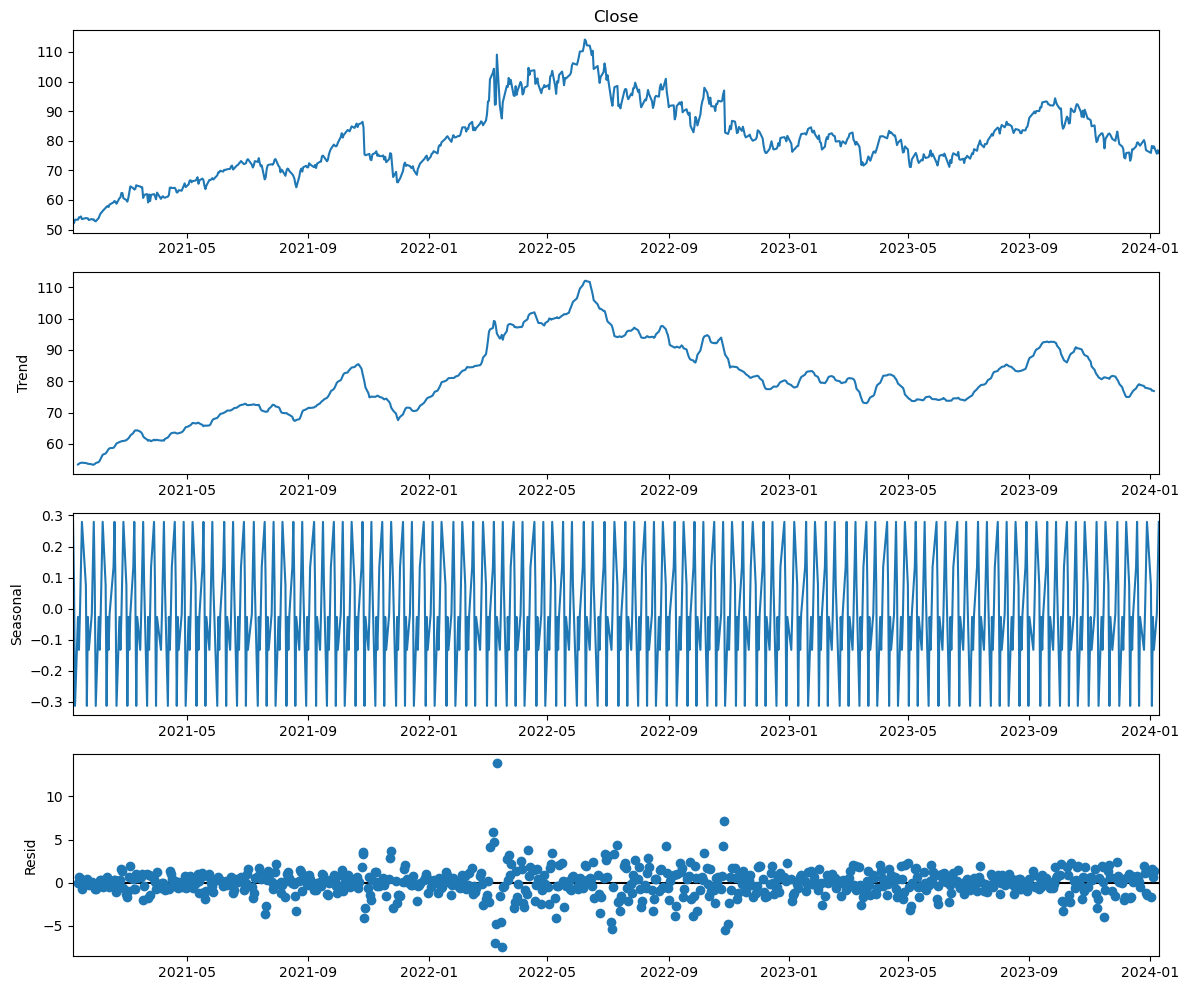

In [246]:
decomp = seasonal_decompose(df.Close, period=7)
fig = decomp.plot()
fig.set_size_inches((12, 10))
fig.tight_layout()
plt.show()

# Modelling

## ARIMA

In [247]:
def plot_acf_pacf(series, figsize=(15, 8), dropna=True):
    if dropna:
        series = series.dropna()

    plt.figure(figsize=figsize)
    plt.subplot(211)
    plt.plot(series)

    ax1 = plt.subplot(223)
    plot_acf(series, lags=50, ax=ax1, title='ACF', color='b', alpha=None);

    ax2 = plt.subplot(224)
    plot_pacf(series, lags=50, ax=ax2, title='PACF', color='r', alpha=None);

### Find number of differencing

C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



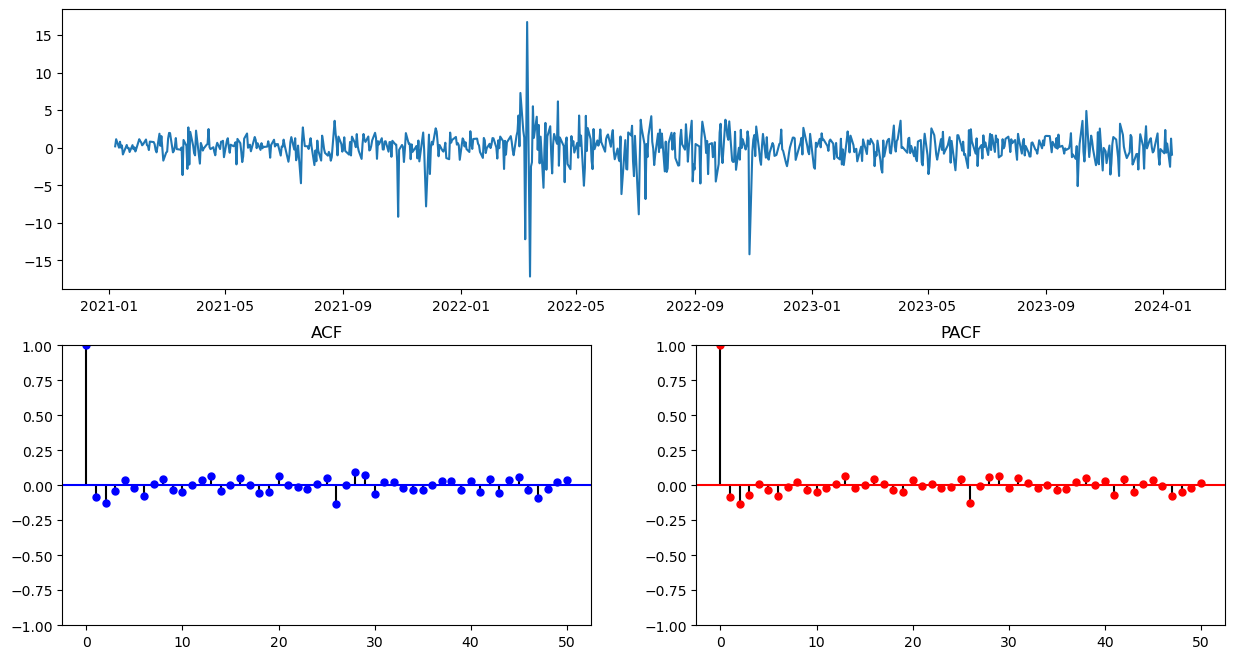

In [248]:
# 1st diff
plot_acf_pacf(df.Close.diff())

C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



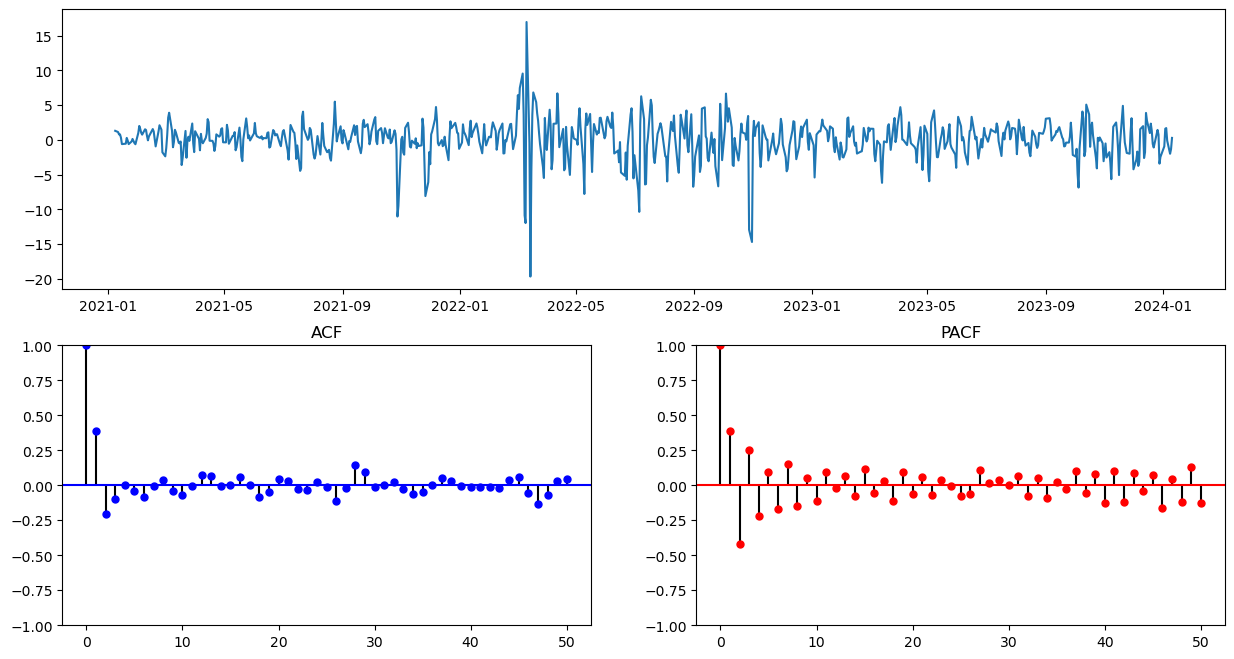

In [249]:
# 2nd diff
plot_acf_pacf(df.Close.diff(2))

Dengan informasi diatas, kita dapat mengambil kesimpulan untuk model ARIMA yang akan digunakan adalah <b>ARIMA(1, 2, 2)</b>
dimana:
- p : 1
- d : 2
- q : 2

### Training Model

In [250]:
p, d, q = 1, 2, 2

order = (p, d, q)
order_list = [p, d, q]

arima_model = sm.tsa.arima.ARIMA(y_train, order=order)
arima_model = arima_model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  606
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1317.450
Date:                Mon, 15 Jan 2024   AIC                           2642.901
Time:                        15:45:35   BIC                           2660.515
Sample:                             0   HQIC                          2649.755
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9878      0.016    -60.841      0.000      -1.020      -0.956
ma.L1         -0.0018     14.197     -0.000      1.000     -27.827      27.823
ma.L2         -0.9982     14.172     -0.070      0.944     -28.775      26.779
sigma2         4.5389     64.429      0.070      0.944    -121.739     130.817
===================================================================================
Ljung-Box (L1) (Q):                   5.48   Jarque-Bera (JB):              8055.70
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

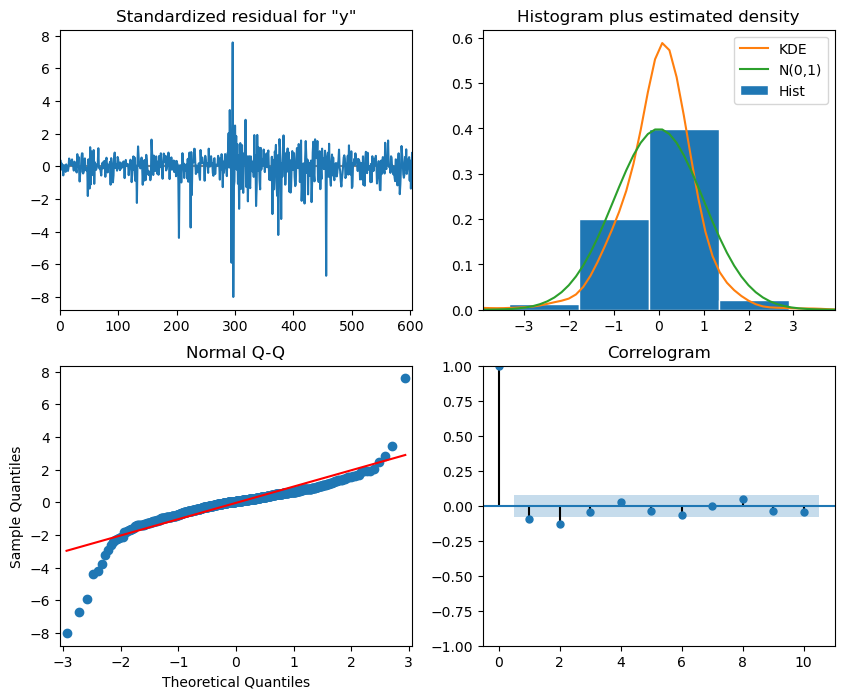

In [251]:
arima_model.plot_diagnostics(figsize=(10, 8))
plt.show()

## Forecasting

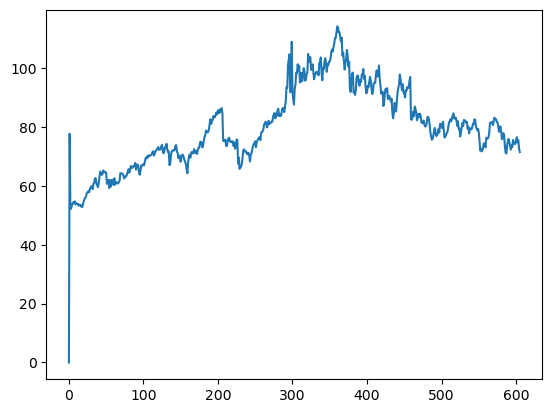

In [252]:
plt.plot(arima_model.predict())

In [253]:
# save model
arima_model.save('model/arima_model.pickle')

## Auto-ARIMA

In [254]:
auto_arima_model = auto_arima(y_train, 
                               seasonal=False, 
                               m=7,
                               information_criterion='aic', 
                               trace=True, 
                               suppress_warnings=True, 
                               random_state=42)

C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2624.632, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2637.966, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2635.241, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2633.345, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2636.133, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2622.786, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2622.664, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2623.140, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2622.511, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2623.055, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2624.912, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2620.950, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2631.561, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2633.437, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [255]:
# best p, d, q value by auto arima
auto_arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [256]:
# model summary
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  606
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1307.475
Date:                Mon, 15 Jan 2024   AIC                           2620.950
Time:                        15:45:46   BIC                           2634.165
Sample:                             0   HQIC                          2626.092
                                - 606                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6297      0.085      7.380      0.000       0.462       0.797
ma.L1         -0.7690      0.068    -11.354      0.000      -0.902      -0.636
sigma2         4.4115      0.124     35.628      0.0

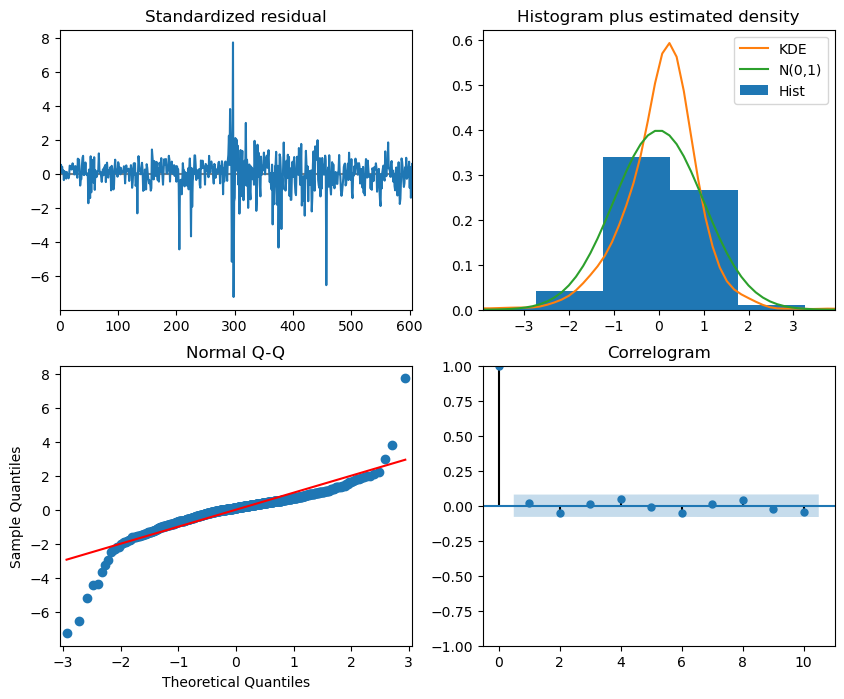

In [257]:
auto_arima_model.plot_diagnostics(figsize=(10, 8))
plt.show()

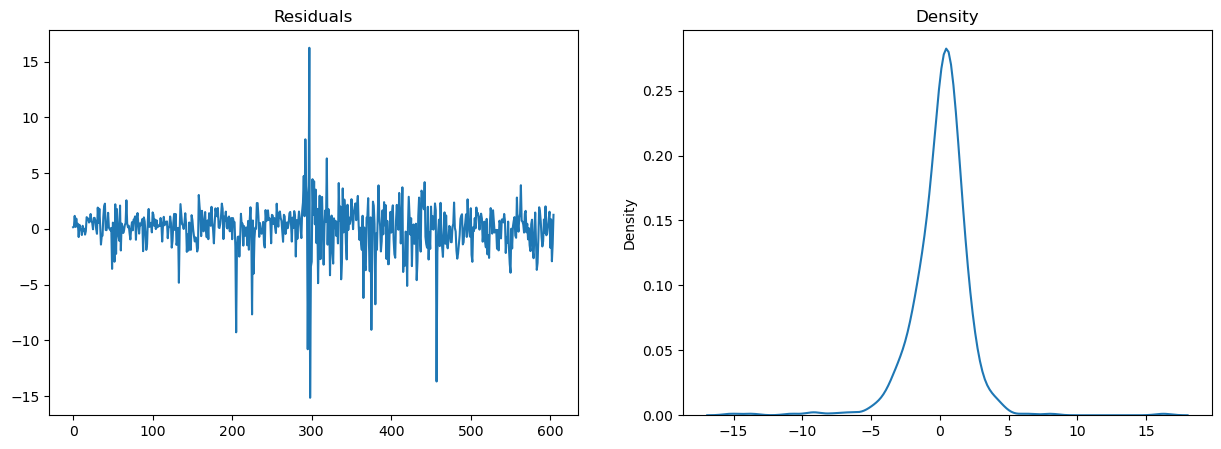

In [258]:
residuals = auto_arima_model.resid()[1:]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Residuals')
ax[0].plot(residuals)

ax[1].set_title('Density')
sns.kdeplot(residuals, ax=ax[1])
plt.show()

C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



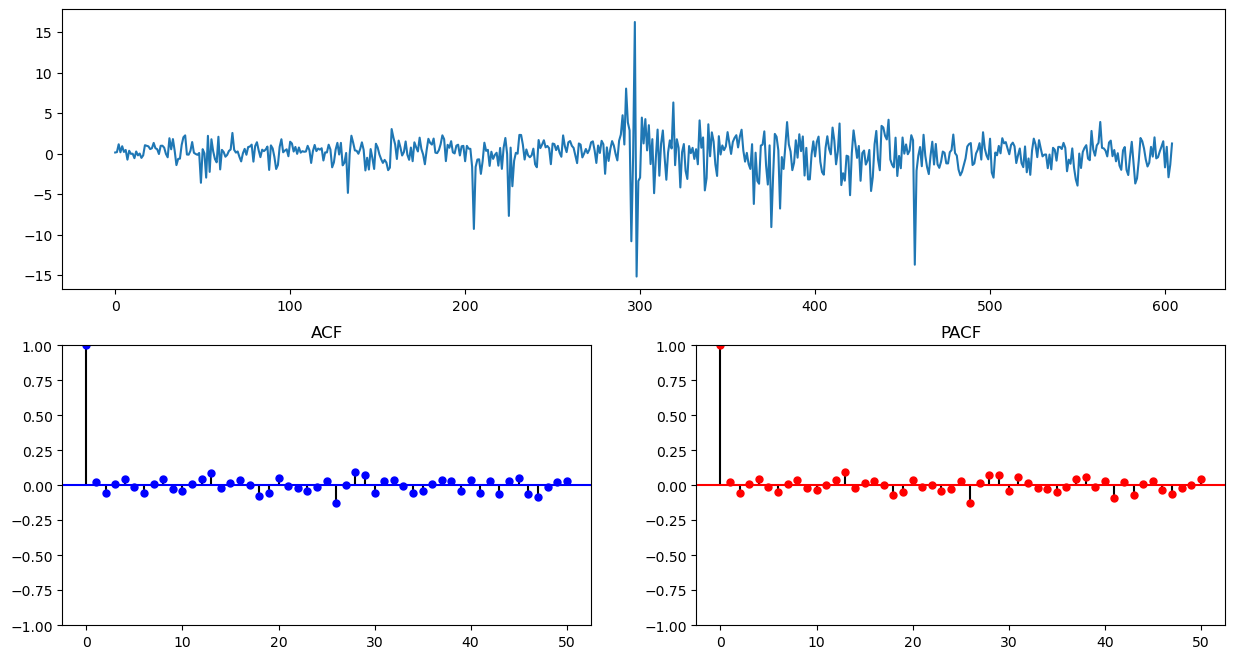

In [259]:
plot_acf_pacf(residuals, dropna=False)

### Forecasting

In [260]:
temp = df.copy()

In [261]:
auto_arima_model.predict(14)

array([73.38138418, 73.43262785, 73.46489348, 73.48520959, 73.49800165,
       73.50605619, 73.51112774, 73.51432105, 73.51633172, 73.51759774,
       73.51839489, 73.51889682, 73.51921286, 73.51941185])

In [262]:
# save model

with open('model/auto_arima_model.pkl', 'wb') as pkl:
    pickle.dump(auto_arima_model, pkl)

## LSTM

In [263]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path , model_name),
                                            verbose=0,
                                            monitor='val_loss',
                                            save_best_only=True)

In [264]:
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
      # layers.LSTM(128, activation='tanh'),
      tf.keras.layers.LSTM(128, activation='relu'), # relu turns out better than the default 'tanh'
      tf.keras.layers.Dense(1)
    ], name='lstm_model')

lstm_model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                )

lstm_model.fit(train_windows, train_labels, 
            epochs=100, 
            verbose=1, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=lstm_model.name)])

Epoch 1/100
 1/19 [>.............................] - ETA: 17s - loss: 72.4612INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 3s 84ms/step - loss: 55.1315 - val_loss: 29.5944
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 9.4502 INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 9.4502 - val_loss: 2.2852
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 2.2453INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 80ms/step - loss: 2.1875 - val_loss: 1.7072
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9930 - val_loss: 1.7582
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9865 - val_loss: 1.7704
Epoch 6/100
 1/19 [>.............................] - ETA: 0s - loss: 1.8548INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.9906 - val_loss: 1.6737
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 1.9947 - val_loss: 1.6874
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0145 - val_loss: 1.7005
Epoch 9/100
 1/19 [>.............................] - ETA: 0s - loss: 2.1438INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 2s 98ms/step - loss: 1.9672 - val_loss: 1.6488
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 1.9602 - val_loss: 1.8302
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 2.0821 - val_loss: 1.6522
Epoch 12/100
19/19 [==============================] - ETA: 0s - loss: 1.9553INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.9553 - val_loss: 1.6357
Epoch 13/100
18/19 [===========================>..] - ETA: 0s - loss: 2.0103INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 83ms/step - loss: 2.0299 - val_loss: 1.6285
Epoch 14/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9519 - val_loss: 1.7101
Epoch 15/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9448 - val_loss: 1.6432
Epoch 16/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9322 - val_loss: 1.7582
Epoch 17/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0532 - val_loss: 1.7549
Epoch 18/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9383 - val_loss: 1.6427
Epoch 19/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9534 - val_loss: 1.6375
Epoch 20/100
 1/19 [>.............................] - ETA: 0s - loss: 2.1659INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 79ms/step - loss: 1.9560 - val_loss: 1.6186
Epoch 21/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9539 - val_loss: 1.7230
Epoch 22/100
 1/19 [>.............................] - ETA: 0s - loss: 2.0717INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 75ms/step - loss: 2.0057 - val_loss: 1.6168
Epoch 23/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9720 - val_loss: 1.6186
Epoch 24/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9471 - val_loss: 1.7308
Epoch 25/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0142 - val_loss: 1.7213
Epoch 26/100
 1/19 [>.............................] - ETA: 0s - loss: 1.8154INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 79ms/step - loss: 1.9951 - val_loss: 1.5596
Epoch 27/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8899 - val_loss: 1.6173
Epoch 28/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9859 - val_loss: 1.7456
Epoch 29/100
 1/19 [>.............................] - ETA: 0s - loss: 2.4278INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 2s 103ms/step - loss: 1.9035 - val_loss: 1.5469
Epoch 30/100
 1/19 [>.............................] - ETA: 0s - loss: 1.8804INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 80ms/step - loss: 1.8695 - val_loss: 1.5292
Epoch 31/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9648 - val_loss: 1.7841
Epoch 32/100
 1/19 [>.............................] - ETA: 0s - loss: 2.1949INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 76ms/step - loss: 1.8689 - val_loss: 1.5223
Epoch 33/100
 1/19 [>.............................] - ETA: 0s - loss: 1.9600INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 76ms/step - loss: 1.8148 - val_loss: 1.5131
Epoch 34/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9587 - val_loss: 1.5297
Epoch 35/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0423 - val_loss: 2.0188
Epoch 36/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8899 - val_loss: 1.5574
Epoch 37/100
 1/19 [>.............................] - ETA: 0s - loss: 1.6933INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.7806 - val_loss: 1.4841
Epoch 38/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7962 - val_loss: 1.7789
Epoch 39/100
 1/19 [>.............................] - ETA: 0s - loss: 2.2586INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 76ms/step - loss: 1.8652 - val_loss: 1.4788
Epoch 40/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7470 - val_loss: 1.7337
Epoch 41/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8234 - val_loss: 1.5329
Epoch 42/100
 1/19 [>.............................] - ETA: 0s - loss: 1.3413INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 2s 102ms/step - loss: 1.8121 - val_loss: 1.4362
Epoch 43/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8060 - val_loss: 1.5439
Epoch 44/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8266 - val_loss: 1.5128
Epoch 45/100
 1/19 [>.............................] - ETA: 0s - loss: 1.2845INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 74ms/step - loss: 1.7761 - val_loss: 1.4139
Epoch 46/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6977 - val_loss: 1.4782
Epoch 47/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7843 - val_loss: 1.5349
Epoch 48/100
 1/19 [>.............................] - ETA: 0s - loss: 1.9410INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.7652 - val_loss: 1.3927
Epoch 49/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6986 - val_loss: 1.4406
Epoch 50/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7512 - val_loss: 1.5030
Epoch 51/100
 1/19 [>.............................] - ETA: 0s - loss: 1.9779INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 79ms/step - loss: 1.6639 - val_loss: 1.3557
Epoch 52/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6911 - val_loss: 1.5835
Epoch 53/100
 1/19 [>.............................] - ETA: 0s - loss: 1.4176INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 80ms/step - loss: 1.7053 - val_loss: 1.3473
Epoch 54/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6618 - val_loss: 1.4263
Epoch 55/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6578 - val_loss: 1.3800
Epoch 56/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6418 - val_loss: 1.3546
Epoch 57/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6899 - val_loss: 1.4657
Epoch 58/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7502 - val_loss: 2.2690
Epoch 59/100
19/19 [==============================] - 0s 4ms/step - loss: 2.1000 - val_loss: 1.6063
Epoch 60/100
 1/19 [>.............................] - ETA: 0s - loss: 1.2628INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.7284 - val_loss: 1.3470
Epoch 61/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6793 - val_loss: 1.7345
Epoch 62/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7160 - val_loss: 1.4071
Epoch 63/100
 1/19 [>.............................] - ETA: 0s - loss: 1.3822INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 2s 101ms/step - loss: 1.6311 - val_loss: 1.3240
Epoch 64/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6413 - val_loss: 1.3456
Epoch 65/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6884 - val_loss: 1.5109
Epoch 66/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6621 - val_loss: 1.3510
Epoch 67/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6621 - val_loss: 1.3673
Epoch 68/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6236 - val_loss: 1.3789
Epoch 69/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6228 - val_loss: 1.3656
Epoch 70/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6124 - val_loss: 1.3843
Epoch 71/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5995 - val_loss: 1.3914
Epoch 72/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6491 - val_loss: 1.3389
Epoch 73/10

INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 76ms/step - loss: 1.5881 - val_loss: 1.2821
Epoch 74/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6318 - val_loss: 1.6131
Epoch 75/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6822 - val_loss: 1.5504
Epoch 76/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6583 - val_loss: 1.3879
Epoch 77/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8438 - val_loss: 2.2246
Epoch 78/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7968 - val_loss: 1.4497
Epoch 79/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7842 - val_loss: 1.4573
Epoch 80/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6519 - val_loss: 1.3029
Epoch 81/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6789 - val_loss: 1.3897
Epoch 82/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6598 - val_loss: 1.5440
Epoch 83/100

INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 76ms/step - loss: 1.5609 - val_loss: 1.2656
Epoch 84/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5510 - val_loss: 1.2729
Epoch 85/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6008 - val_loss: 1.2778
Epoch 86/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5921 - val_loss: 1.2811
Epoch 87/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5584 - val_loss: 1.6019
Epoch 88/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6414 - val_loss: 1.4573
Epoch 89/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5780 - val_loss: 1.3886
Epoch 90/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5009 - val_loss: 1.3558
Epoch 91/100
19/19 [==============================] - 0s 4ms/step - loss: 1.6403 - val_loss: 1.2743
Epoch 92/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5277 - val_loss: 1.2939
Epoch 93/100

INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 77ms/step - loss: 1.5919 - val_loss: 1.2306
Epoch 96/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5595 - val_loss: 1.3515
Epoch 97/100
19/19 [==============================] - 0s 4ms/step - loss: 1.5463 - val_loss: 1.2956
Epoch 98/100
 1/19 [>.............................] - ETA: 0s - loss: 1.6701INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model\assets


19/19 [==============================] - 1s 75ms/step - loss: 1.4832 - val_loss: 1.2291
Epoch 99/100
19/19 [==============================] - 0s 4ms/step - loss: 1.4821 - val_loss: 1.3803
Epoch 100/100
19/19 [==============================] - 0s 4ms/step - loss: 1.4485 - val_loss: 1.2531


In [265]:
lstm_model.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 2ms/step - loss: 1.2531


1.2530863285064697

In [266]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [267]:
# Make predictions
lstm_model_preds = make_preds(lstm_model, test_windows)
lstm_model_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([74.00384, 74.68898, 74.50178, 75.09751, 74.74777], dtype=float32)>

In [268]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season
     

def evaluate_preds(y_true, y_pred):
    # Turning datatype to float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)


    # MAE
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)

    # MSE
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)

    # RMSE
    rmse = tf.sqrt(mse)

    # sMAPE (MAPE and sMAPE is different)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred) 

    # MASE
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {'MAE': mae.numpy(),
          'MSE': mse.numpy(),
          'RMSE': rmse.numpy(),
          'MAPE': mape.numpy(),
          'MASE': mase.numpy()} # convert to numpy so that it does not return as a tensor -> will create an error

In [269]:
# Evaluate preds
lstm_model_result = evaluate_preds(test_labels, lstm_model_preds)
lstm_model_result

{'MAE': 6.841297,
 'MSE': 70.89952,
 'RMSE': 8.165585,
 'MAPE': 8.297126,
 'MASE': 5.877741}

In [270]:
from datetime import timedelta

def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + timedelta(days=offset)
    end_date = start_date + timedelta(days=into_future)

    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [271]:
last_timestep = df.Close.index[-1]
type(last_timestep)

datetime.date

In [272]:
# Future dates we want to predict
INTO_FUTURE = 14 # 2 WEEKS

# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE
                                  )
next_time_steps

array(['2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
       '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18',
       '2024-01-19', '2024-01-20', '2024-01-21', '2024-01-22',
       '2024-01-23', '2024-01-24'], dtype='datetime64[D]')

In [273]:
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE)->list:
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]

    for _ in range(INTO_FUTURE):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction {tf.squeeze(future_pred).numpy()}\n")

        future_forecast.append(tf.squeeze(future_pred).numpy())

        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
    return future_forecast


In [274]:
future_forecast = make_future_forecasts(values=full_labels, model=lstm_model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE)

Predicting on:
 [[75.89]
 [78.25]
 [77.59]
 [78.14]
 [75.6 ]
 [76.81]
 [75.89]] -> Prediction 75.98523712158203

Predicting on:
 [78.25       77.59       78.14       75.6        76.81       75.89
 75.98523712] -> Prediction 75.60615539550781

Predicting on:
 [77.59       78.14       75.6        76.81       75.89       75.98523712
 75.6061554 ] -> Prediction 75.42892456054688

Predicting on:
 [78.14       75.6        76.81       75.89       75.98523712 75.6061554
 75.42892456] -> Prediction 75.09387969970703

Predicting on:
 [75.6        76.81       75.89       75.98523712 75.6061554  75.42892456
 75.0938797 ] -> Prediction 74.95111083984375

Predicting on:
 [76.81       75.89       75.98523712 75.6061554  75.42892456 75.0938797
 74.95111084] -> Prediction 74.67616271972656

Predicting on:
 [75.89       75.98523712 75.6061554  75.42892456 75.0938797  74.95111084
 74.67616272] -> Prediction 74.47755432128906

Predicting on:
 [75.98523712 75.6061554  75.42892456 75.0938797  74.95111084 74

In [275]:
future_forecast

[75.98524,
 75.606155,
 75.428925,
 75.09388,
 74.95111,
 74.67616,
 74.477554,
 74.2414,
 74.028534,
 73.806946,
 73.598335,
 73.38454,
 73.17819,
 72.97168]

### Plot Forecasting

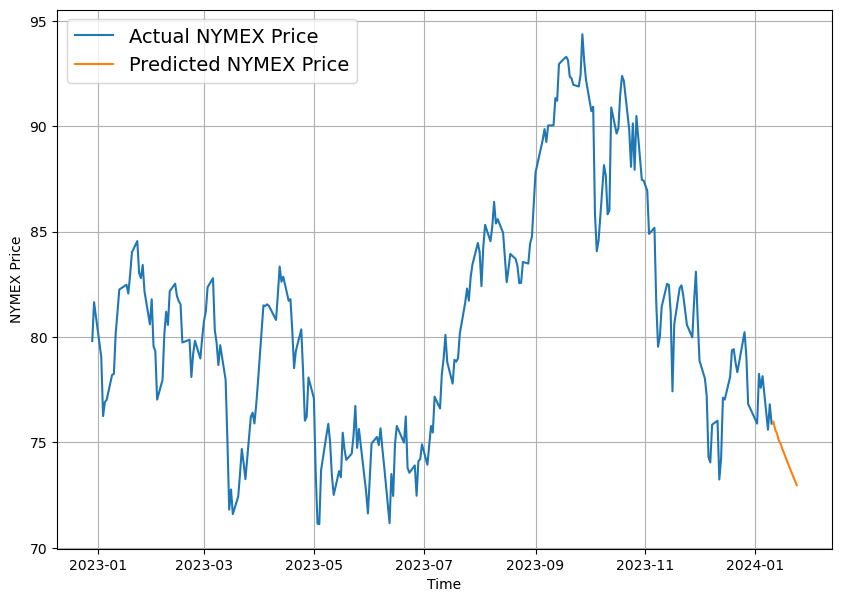

In [276]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps, prices, start=500, format='-', label='Actual NYMEX Price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted NYMEX Price')

In [277]:
# save model
lstm_model.save('model/lstm_model.h5')

### Multivariate

In [278]:
tf.random.set_seed(42)

multivariate_model = tf.keras.Sequential([
    tf.keras.layers.Dense(132, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='multivariate_model')


# Compile the model
multivariate_model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit the model
multivariate_model.fit(train_windows, train_labels, 
            epochs=100, 
            batch_size=128,
            verbose=1,
            validation_data=(test_windows ,test_labels),
            callbacks=[create_model_checkpoint(model_name=multivariate_model.name)]
           )

Epoch 1/100
1/5 [=====>........................] - ETA: 1s - loss: 45.1800 - mae: 45.1800 - mse: 2107.6353INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 1s 125ms/step - loss: 36.5363 - mae: 36.5363 - mse: 1423.3363 - val_loss: 21.7724 - val_mae: 21.7724 - val_mse: 481.0666
Epoch 2/100
1/5 [=====>........................] - ETA: 0s - loss: 21.0432 - mae: 21.0432 - mse: 460.7740INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 1s 125ms/step - loss: 12.2757 - mae: 12.2757 - mse: 203.1948 - val_loss: 3.3249 - val_mae: 3.3249 - val_mse: 16.4645
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 7.8071 - mae: 7.8071 - mse: 78.6999 - val_loss: 10.6664 - val_mae: 10.6664 - val_mse: 120.5056
Epoch 4/100
1/5 [=====>........................] - ETA: 0s - loss: 10.2583 - mae: 10.2583 - mse: 117.8614INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 104ms/step - loss: 7.9246 - mae: 7.9246 - mse: 77.6529 - val_loss: 2.3276 - val_mae: 2.3276 - val_mse: 9.2896
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 3.5465 - mae: 3.5465 - mse: 19.2207 - val_loss: 5.4252 - val_mae: 5.4252 - val_mse: 34.4282
Epoch 6/100
1/5 [=====>........................] - ETA: 0s - loss: 5.2949 - mae: 5.2949 - mse: 34.9581INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 103ms/step - loss: 4.4494 - mae: 4.4494 - mse: 26.5663 - val_loss: 1.8594 - val_mae: 1.8594 - val_mse: 5.6198
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 2.8349 - mae: 2.8349 - mse: 14.9611 - val_loss: 3.0611 - val_mae: 3.0611 - val_mse: 14.5474
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 2.5763 - mae: 2.5763 - mse: 12.1830 - val_loss: 2.3314 - val_mae: 2.3314 - val_mse: 7.7650
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 2.5069 - mae: 2.5069 - mse: 10.3756 - val_loss: 1.8949 - val_mae: 1.8949 - val_mse: 6.0104
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 2.2997 - mae: 2.2997 - mse: 10.6126 - val_loss: 1.9640 - val_mae: 1.9640 - val_mse: 6.6020
Epoch 11/100
5/5 [==============================] - 0s 8ms/step - loss: 2.2292 - mae: 2.2292 - mse: 9.2615 - val_loss: 1.9251 - val_mae: 1.9251 - val_mse: 5.8163
Epoch 12/100
5/5 [==================

INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 104ms/step - loss: 2.1725 - mae: 2.1725 - mse: 9.2399 - val_loss: 1.8563 - val_mae: 1.8563 - val_mse: 5.5473
Epoch 14/100
5/5 [==============================] - 0s 8ms/step - loss: 2.1232 - mae: 2.1232 - mse: 8.6597 - val_loss: 1.8886 - val_mae: 1.8886 - val_mse: 6.0040
Epoch 15/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0388 - mae: 2.0388 - mse: 8.0619INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 122ms/step - loss: 2.1291 - mae: 2.1291 - mse: 9.2055 - val_loss: 1.8391 - val_mae: 1.8391 - val_mse: 5.5781
Epoch 16/100
1/5 [=====>........................] - ETA: 0s - loss: 1.8296 - mae: 1.8296 - mse: 5.8722INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 104ms/step - loss: 2.1161 - mae: 2.1161 - mse: 8.6246 - val_loss: 1.8331 - val_mae: 1.8331 - val_mse: 5.5249
Epoch 17/100
5/5 [==============================] - 0s 9ms/step - loss: 2.0975 - mae: 2.0975 - mse: 8.8168 - val_loss: 1.8490 - val_mae: 1.8490 - val_mse: 5.6759
Epoch 18/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0295 - mae: 2.0295 - mse: 8.0581INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 105ms/step - loss: 2.0998 - mae: 2.0998 - mse: 8.6402 - val_loss: 1.8265 - val_mae: 1.8265 - val_mse: 5.4984
Epoch 19/100
5/5 [==============================] - 0s 9ms/step - loss: 2.0877 - mae: 2.0877 - mse: 8.6729 - val_loss: 1.8523 - val_mae: 1.8523 - val_mse: 5.7243
Epoch 20/100
1/5 [=====>........................] - ETA: 0s - loss: 2.1483 - mae: 2.1483 - mse: 8.6806INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 105ms/step - loss: 2.0905 - mae: 2.0905 - mse: 8.6172 - val_loss: 1.8173 - val_mae: 1.8173 - val_mse: 5.4307
Epoch 21/100
5/5 [==============================] - 0s 9ms/step - loss: 2.0845 - mae: 2.0845 - mse: 8.7179 - val_loss: 1.8508 - val_mae: 1.8508 - val_mse: 5.7417
Epoch 22/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9843 - mae: 1.9843 - mse: 7.8626INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 114ms/step - loss: 2.0782 - mae: 2.0782 - mse: 8.5637 - val_loss: 1.8090 - val_mae: 1.8090 - val_mse: 5.3679
Epoch 23/100
5/5 [==============================] - 0s 10ms/step - loss: 2.0791 - mae: 2.0791 - mse: 8.6150 - val_loss: 1.8284 - val_mae: 1.8284 - val_mse: 5.5687
Epoch 24/100
1/5 [=====>........................] - ETA: 0s - loss: 2.2385 - mae: 2.2385 - mse: 10.5416INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 109ms/step - loss: 2.0700 - mae: 2.0700 - mse: 8.4149 - val_loss: 1.8010 - val_mae: 1.8010 - val_mse: 5.3080
Epoch 25/100
5/5 [==============================] - 0s 7ms/step - loss: 2.0568 - mae: 2.0568 - mse: 8.3718 - val_loss: 1.8408 - val_mae: 1.8408 - val_mse: 5.7137
Epoch 26/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0011 - mae: 2.0011 - mse: 7.3499INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 116ms/step - loss: 2.0681 - mae: 2.0681 - mse: 8.7870 - val_loss: 1.7974 - val_mae: 1.7974 - val_mse: 5.2340
Epoch 27/100
5/5 [==============================] - 0s 8ms/step - loss: 2.0690 - mae: 2.0690 - mse: 8.2738 - val_loss: 1.7988 - val_mae: 1.7988 - val_mse: 5.3699
Epoch 28/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9274 - mae: 1.9274 - mse: 7.6662INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 2.0612 - mae: 2.0612 - mse: 8.6226 - val_loss: 1.7846 - val_mae: 1.7846 - val_mse: 5.2602
Epoch 29/100
5/5 [==============================] - 0s 8ms/step - loss: 2.0746 - mae: 2.0746 - mse: 8.2979 - val_loss: 1.8115 - val_mae: 1.8115 - val_mse: 5.5105
Epoch 30/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9643 - mae: 1.9643 - mse: 7.9868INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 103ms/step - loss: 2.0678 - mae: 2.0678 - mse: 8.8391 - val_loss: 1.7765 - val_mae: 1.7765 - val_mse: 5.1383
Epoch 31/100
5/5 [==============================] - 0s 9ms/step - loss: 2.0656 - mae: 2.0656 - mse: 8.1005 - val_loss: 1.8111 - val_mae: 1.8111 - val_mse: 5.5409
Epoch 32/100
5/5 [==============================] - 0s 9ms/step - loss: 2.0914 - mae: 2.0914 - mse: 8.9951 - val_loss: 1.7835 - val_mae: 1.7835 - val_mse: 5.1087
Epoch 33/100
5/5 [==============================] - 0s 9ms/step - loss: 2.1848 - mae: 2.1848 - mse: 8.5512 - val_loss: 1.8491 - val_mae: 1.8491 - val_mse: 5.8463
Epoch 34/100
5/5 [==============================] - 0s 8ms/step - loss: 2.0877 - mae: 2.0877 - mse: 9.0547 - val_loss: 1.7815 - val_mae: 1.7815 - val_mse: 5.0770
Epoch 35/100
5/5 [==============================] - 0s 8ms/step - loss: 2.0722 - mae: 2.0722 - mse: 8.0599 - val_loss: 1.8322 - val_mae: 1.8322 - val_mse: 5.7354
Epoch 36/100
1/5 [=====>...............

INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 108ms/step - loss: 2.0670 - mae: 2.0670 - mse: 8.7599 - val_loss: 1.7732 - val_mae: 1.7732 - val_mse: 5.0279
Epoch 37/100
5/5 [==============================] - 0s 7ms/step - loss: 2.0570 - mae: 2.0570 - mse: 8.2510 - val_loss: 1.9239 - val_mae: 1.9239 - val_mse: 6.4462
Epoch 38/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0788 - mae: 2.0788 - mse: 8.7782INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 104ms/step - loss: 2.0705 - mae: 2.0705 - mse: 8.5781 - val_loss: 1.7543 - val_mae: 1.7543 - val_mse: 4.9481
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9976 - mae: 1.9976 - mse: 8.0322 - val_loss: 1.7875 - val_mae: 1.7875 - val_mse: 5.4298
Epoch 40/100
1/5 [=====>........................] - ETA: 0s - loss: 1.8095 - mae: 1.8095 - mse: 6.0089INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 2.0085 - mae: 2.0085 - mse: 7.8826 - val_loss: 1.7265 - val_mae: 1.7265 - val_mse: 4.9201
Epoch 41/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9947 - mae: 1.9947 - mse: 8.1353 - val_loss: 1.7377 - val_mae: 1.7377 - val_mse: 5.0620
Epoch 42/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9230 - mae: 1.9230 - mse: 7.0465INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.9758 - mae: 1.9758 - mse: 7.7317 - val_loss: 1.7222 - val_mae: 1.7222 - val_mse: 4.9216
Epoch 43/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9728 - mae: 1.9728 - mse: 7.8416 - val_loss: 1.7387 - val_mae: 1.7387 - val_mse: 5.1093
Epoch 44/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0945 - mae: 2.0945 - mse: 9.0739INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 124ms/step - loss: 1.9663 - mae: 1.9663 - mse: 7.9388 - val_loss: 1.7056 - val_mae: 1.7056 - val_mse: 4.7868
Epoch 45/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9891 - mae: 1.9891 - mse: 7.8699 - val_loss: 1.7292 - val_mae: 1.7292 - val_mse: 5.0584
Epoch 46/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9691 - mae: 1.9691 - mse: 7.6760 - val_loss: 1.7120 - val_mae: 1.7120 - val_mse: 4.9326
Epoch 47/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9890 - mae: 1.9890 - mse: 7.9236INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.9528 - mae: 1.9528 - mse: 7.8159 - val_loss: 1.6941 - val_mae: 1.6941 - val_mse: 4.7580
Epoch 48/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9486 - mae: 1.9486 - mse: 7.5467 - val_loss: 1.8049 - val_mae: 1.8049 - val_mse: 5.6541
Epoch 49/100
1/5 [=====>........................] - ETA: 0s - loss: 2.0371 - mae: 2.0371 - mse: 8.3740INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.9798 - mae: 1.9798 - mse: 7.9637 - val_loss: 1.6809 - val_mae: 1.6809 - val_mse: 4.6267
Epoch 50/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9367 - mae: 1.9367 - mse: 7.5560 - val_loss: 1.6873 - val_mae: 1.6873 - val_mse: 4.7838
Epoch 51/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9479 - mae: 1.9479 - mse: 7.4280 - val_loss: 1.7328 - val_mae: 1.7328 - val_mse: 5.1413
Epoch 52/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9488 - mae: 1.9488 - mse: 7.8174 - val_loss: 1.6848 - val_mae: 1.6848 - val_mse: 4.5540
Epoch 53/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9600 - mae: 1.9600 - mse: 7.6334 - val_loss: 1.6923 - val_mae: 1.6923 - val_mse: 4.8651
Epoch 54/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9584 - mae: 1.9584 - mse: 8.4194INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 100ms/step - loss: 1.9077 - mae: 1.9077 - mse: 7.3615 - val_loss: 1.6547 - val_mae: 1.6547 - val_mse: 4.4932
Epoch 55/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9870 - mae: 1.9870 - mse: 7.2518INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 116ms/step - loss: 1.9253 - mae: 1.9253 - mse: 7.5198 - val_loss: 1.6526 - val_mae: 1.6526 - val_mse: 4.5488
Epoch 56/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9179 - mae: 1.9179 - mse: 7.1218 - val_loss: 1.6693 - val_mae: 1.6693 - val_mse: 4.7343
Epoch 57/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9037 - mae: 1.9037 - mse: 7.5464INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.9263 - mae: 1.9263 - mse: 7.6119 - val_loss: 1.6374 - val_mae: 1.6374 - val_mse: 4.4326
Epoch 58/100
5/5 [==============================] - 0s 7ms/step - loss: 1.9011 - mae: 1.9011 - mse: 7.3825 - val_loss: 1.6376 - val_mae: 1.6376 - val_mse: 4.4840
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 1.8824 - mae: 1.8824 - mse: 7.1367 - val_loss: 1.6493 - val_mae: 1.6493 - val_mse: 4.6173
Epoch 60/100
1/5 [=====>........................] - ETA: 0s - loss: 1.7987 - mae: 1.7987 - mse: 5.8835INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.8731 - mae: 1.8731 - mse: 7.2124 - val_loss: 1.6231 - val_mae: 1.6231 - val_mse: 4.3737
Epoch 61/100
1/5 [=====>........................] - ETA: 0s - loss: 1.6389 - mae: 1.6389 - mse: 4.3488INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 105ms/step - loss: 1.8841 - mae: 1.8841 - mse: 7.1639 - val_loss: 1.6209 - val_mae: 1.6209 - val_mse: 4.3926
Epoch 62/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8653 - mae: 1.8653 - mse: 6.9671 - val_loss: 1.6792 - val_mae: 1.6792 - val_mse: 4.8707
Epoch 63/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8789 - mae: 1.8789 - mse: 7.3308 - val_loss: 1.6225 - val_mae: 1.6225 - val_mse: 4.2392
Epoch 64/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8558 - mae: 1.8558 - mse: 6.9593 - val_loss: 1.6405 - val_mae: 1.6405 - val_mse: 4.6122
Epoch 65/100
1/5 [=====>........................] - ETA: 0s - loss: 1.7414 - mae: 1.7414 - mse: 6.6664INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 117ms/step - loss: 1.8721 - mae: 1.8721 - mse: 7.1534 - val_loss: 1.6157 - val_mae: 1.6157 - val_mse: 4.1889
Epoch 66/100
1/5 [=====>........................] - ETA: 0s - loss: 1.8754 - mae: 1.8754 - mse: 7.0423INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 108ms/step - loss: 1.8609 - mae: 1.8609 - mse: 7.1438 - val_loss: 1.5928 - val_mae: 1.5928 - val_mse: 4.2318
Epoch 67/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8996 - mae: 1.8996 - mse: 6.9602 - val_loss: 1.7156 - val_mae: 1.7156 - val_mse: 5.1774
Epoch 68/100
5/5 [==============================] - 0s 8ms/step - loss: 1.8345 - mae: 1.8345 - mse: 6.9958 - val_loss: 1.6678 - val_mae: 1.6678 - val_mse: 4.2947
Epoch 69/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8933 - mae: 1.8933 - mse: 7.2703 - val_loss: 1.6365 - val_mae: 1.6365 - val_mse: 4.6407
Epoch 70/100
5/5 [==============================] - 0s 7ms/step - loss: 1.8984 - mae: 1.8984 - mse: 6.8948 - val_loss: 1.6168 - val_mae: 1.6168 - val_mse: 4.5113
Epoch 71/100
1/5 [=====>........................] - ETA: 0s - loss: 1.7133 - mae: 1.7133 - mse: 6.1841INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 101ms/step - loss: 1.8726 - mae: 1.8726 - mse: 7.1854 - val_loss: 1.5688 - val_mae: 1.5688 - val_mse: 4.0335
Epoch 72/100
1/5 [=====>........................] - ETA: 0s - loss: 1.8073 - mae: 1.8073 - mse: 6.4490INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 1s 189ms/step - loss: 1.8475 - mae: 1.8475 - mse: 7.0503 - val_loss: 1.5594 - val_mae: 1.5594 - val_mse: 4.0452
Epoch 73/100
5/5 [==============================] - 0s 9ms/step - loss: 1.8689 - mae: 1.8689 - mse: 6.8328 - val_loss: 1.6529 - val_mae: 1.6529 - val_mse: 4.7989
Epoch 74/100
5/5 [==============================] - 0s 8ms/step - loss: 1.7999 - mae: 1.7999 - mse: 6.9164 - val_loss: 1.5805 - val_mae: 1.5805 - val_mse: 3.9676
Epoch 75/100
5/5 [==============================] - 0s 9ms/step - loss: 1.8206 - mae: 1.8206 - mse: 6.8836 - val_loss: 1.5709 - val_mae: 1.5709 - val_mse: 4.2067
Epoch 76/100
1/5 [=====>........................] - ETA: 0s - loss: 1.7439 - mae: 1.7439 - mse: 6.4075INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 108ms/step - loss: 1.7853 - mae: 1.7853 - mse: 6.5704 - val_loss: 1.5404 - val_mae: 1.5404 - val_mse: 3.9619
Epoch 77/100
5/5 [==============================] - 0s 8ms/step - loss: 1.7865 - mae: 1.7865 - mse: 6.6111 - val_loss: 1.6057 - val_mae: 1.6057 - val_mse: 4.5070
Epoch 78/100
5/5 [==============================] - 0s 8ms/step - loss: 1.8004 - mae: 1.8004 - mse: 6.6732 - val_loss: 1.5510 - val_mae: 1.5510 - val_mse: 4.0867
Epoch 79/100
1/5 [=====>........................] - ETA: 0s - loss: 1.7344 - mae: 1.7344 - mse: 5.7560INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.7754 - mae: 1.7754 - mse: 6.5072 - val_loss: 1.5379 - val_mae: 1.5379 - val_mse: 3.9988
Epoch 80/100
1/5 [=====>........................] - ETA: 0s - loss: 1.8322 - mae: 1.8322 - mse: 6.3822INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 100ms/step - loss: 1.7763 - mae: 1.7763 - mse: 6.5616 - val_loss: 1.5257 - val_mae: 1.5257 - val_mse: 3.9202
Epoch 81/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7589 - mae: 1.7589 - mse: 6.3884 - val_loss: 1.5288 - val_mae: 1.5288 - val_mse: 3.9575
Epoch 82/100
5/5 [==============================] - 0s 8ms/step - loss: 1.7775 - mae: 1.7775 - mse: 6.4901 - val_loss: 1.5816 - val_mae: 1.5816 - val_mse: 4.3751
Epoch 83/100
1/5 [=====>........................] - ETA: 0s - loss: 1.5946 - mae: 1.5946 - mse: 4.7467INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 102ms/step - loss: 1.7595 - mae: 1.7595 - mse: 6.3910 - val_loss: 1.5099 - val_mae: 1.5099 - val_mse: 3.7417
Epoch 84/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7465 - mae: 1.7465 - mse: 6.4002 - val_loss: 1.5165 - val_mae: 1.5165 - val_mse: 3.9043
Epoch 85/100
1/5 [=====>........................] - ETA: 0s - loss: 1.5807 - mae: 1.5807 - mse: 4.4944INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 117ms/step - loss: 1.7394 - mae: 1.7394 - mse: 6.3226 - val_loss: 1.4986 - val_mae: 1.4986 - val_mse: 3.7116
Epoch 86/100
5/5 [==============================] - 0s 8ms/step - loss: 1.7422 - mae: 1.7422 - mse: 6.2309 - val_loss: 1.6451 - val_mae: 1.6451 - val_mse: 4.8219
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 1.8028 - mae: 1.8028 - mse: 6.4805 - val_loss: 1.5409 - val_mae: 1.5409 - val_mse: 4.1218
Epoch 88/100
5/5 [==============================] - 0s 8ms/step - loss: 1.8786 - mae: 1.8786 - mse: 7.0884 - val_loss: 1.8035 - val_mae: 1.8035 - val_mse: 4.6897
Epoch 89/100
5/5 [==============================] - 0s 8ms/step - loss: 1.9047 - mae: 1.9047 - mse: 6.8343 - val_loss: 1.5423 - val_mae: 1.5423 - val_mse: 4.1499
Epoch 90/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7437 - mae: 1.7437 - mse: 6.1353 - val_loss: 1.5105 - val_mae: 1.5105 - val_mse: 3.9200
Epoch 91/100
5/5 [=====================

INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 105ms/step - loss: 1.7760 - mae: 1.7760 - mse: 6.3706 - val_loss: 1.4865 - val_mae: 1.4865 - val_mse: 3.7622
Epoch 93/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7346 - mae: 1.7346 - mse: 6.0084 - val_loss: 1.6209 - val_mae: 1.6209 - val_mse: 4.6796
Epoch 94/100
1/5 [=====>........................] - ETA: 0s - loss: 1.5864 - mae: 1.5864 - mse: 5.3835INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 103ms/step - loss: 1.7916 - mae: 1.7916 - mse: 6.5773 - val_loss: 1.4818 - val_mae: 1.4818 - val_mse: 3.7455
Epoch 95/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7403 - mae: 1.7403 - mse: 6.3767 - val_loss: 1.4930 - val_mae: 1.4930 - val_mse: 3.5095
Epoch 96/100
1/5 [=====>........................] - ETA: 0s - loss: 1.9346 - mae: 1.9346 - mse: 7.3494INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 100ms/step - loss: 1.7455 - mae: 1.7455 - mse: 6.3468 - val_loss: 1.4621 - val_mae: 1.4621 - val_mse: 3.4747
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 1.7250 - mae: 1.7250 - mse: 6.0862 - val_loss: 1.5053 - val_mae: 1.5053 - val_mse: 3.9518
Epoch 98/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7059 - mae: 1.7059 - mse: 6.0190 - val_loss: 1.4719 - val_mae: 1.4719 - val_mse: 3.7117
Epoch 99/100
1/5 [=====>........................] - ETA: 0s - loss: 1.6071 - mae: 1.6071 - mse: 5.2944INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


INFO:tensorflow:Assets written to: model_experiments\multivariate_model\assets


5/5 [==============================] - 0s 115ms/step - loss: 1.6746 - mae: 1.6746 - mse: 5.9404 - val_loss: 1.4438 - val_mae: 1.4438 - val_mse: 3.4365
Epoch 100/100
5/5 [==============================] - 0s 7ms/step - loss: 1.6828 - mae: 1.6828 - mse: 5.9280 - val_loss: 1.4652 - val_mae: 1.4652 - val_mse: 3.6829


In [279]:
# Make predictions
multivariate_model_preds = make_preds(multivariate_model, test_windows)

# evaluate
multivariate_model_result = evaluate_preds(test_labels, multivariate_model_preds)
multivariate_model_result

{'MAE': 6.848413,
 'MSE': 70.94225,
 'RMSE': 8.186904,
 'MAPE': 8.353624,
 'MASE': 5.883853}

In [280]:
future_forecast = make_future_forecasts(values=full_labels, model=multivariate_model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE)
future_forecast

Predicting on:
 [[75.89]
 [78.25]
 [77.59]
 [78.14]
 [75.6 ]
 [76.81]
 [75.89]] -> Prediction 76.90156555175781

Predicting on:
 [78.25       77.59       78.14       75.6        76.81       75.89
 76.90156555] -> Prediction 77.44966888427734

Predicting on:
 [77.59       78.14       75.6        76.81       75.89       76.90156555
 77.44966888] -> Prediction 77.59024810791016

Predicting on:
 [78.14       75.6        76.81       75.89       76.90156555 77.44966888
 77.59024811] -> Prediction 77.77771759033203

Predicting on:
 [75.6        76.81       75.89       76.90156555 77.44966888 77.59024811
 77.77771759] -> Prediction 77.8261947631836

Predicting on:
 [76.81       75.89       76.90156555 77.44966888 77.59024811 77.77771759
 77.82619476] -> Prediction 78.00139617919922

Predicting on:
 [75.89       76.90156555 77.44966888 77.59024811 77.77771759 77.82619476
 78.00139618] -> Prediction 78.1487808227539

Predicting on:
 [76.90156555 77.44966888 77.59024811 77.77771759 77.82619476 78

[76.901566,
 77.44967,
 77.59025,
 77.77772,
 77.826195,
 78.001396,
 78.14878,
 78.3988,
 78.62716,
 78.82451,
 79.020515,
 79.20687,
 79.39774,
 79.5928]

### Plot forecasting

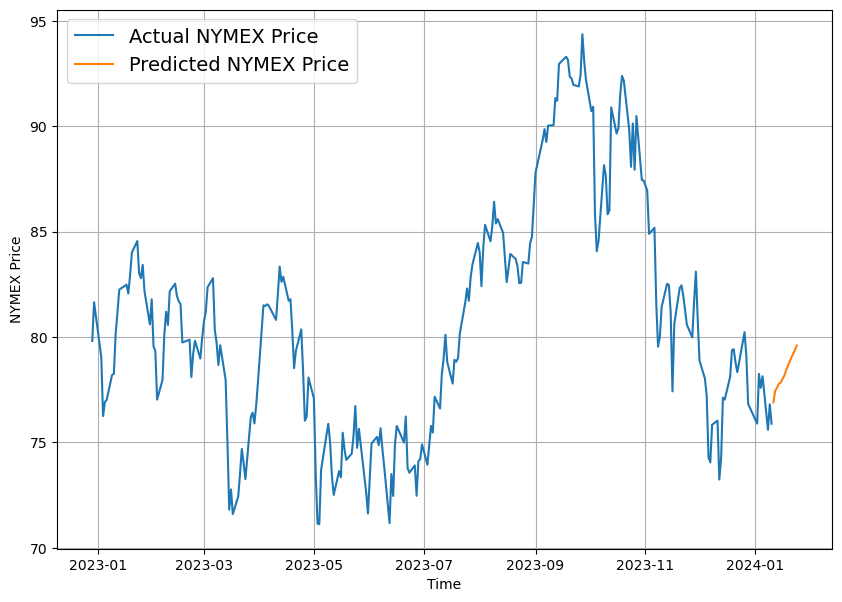

In [281]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps, prices, start=500, format='-', label='Actual NYMEX Price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted NYMEX Price')

In [282]:
# save model
multivariate_model.save('model/multivariate_model.h5')

## Prophet

In [289]:
df = pd.read_csv('data/brentcrudeoil-dailybrentoil.csv', parse_dates=['Date'])
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df.drop(columns=['chg(close)', 'chg(low)', 'chg(high)'], inplace=True)
df.head()

,ds,y,Low,High
0,2021-01-04 23:58:00,50.23,49.97,51.88
1,2021-01-05 23:58:00,51.87,50.01,52.26
2,2021-01-06 23:58:00,52.02,51.21,52.37
3,2021-01-07 23:58:00,52.20,51.89,52.34
4,2021-01-08 23:58:00,53.33,52.31,53.61


In [288]:
model = prophet.Prophet()
model.fit(df)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\LEN0V0\miniconda3\envs\kalla_internship\lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\LEN0V0\AppData\Local\Temp\tmpb0i2_zbd\z0g9ofzm.json
DEBUG:cmdstanpy:input tempfile: C:\Users\LEN0V0\AppData\Local\Temp\tmpb0i2_zbd\m5mhv4b5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\LEN0V0\\miniconda3\\envs\\kalla_internship\\lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=72968', 'data', 'file=C:\\Users\\LEN0V0\\AppData\\Local\\Temp\\tmpb0i2_zbd\\z0g9ofzm.json', 'init=C:\\Users\\LEN0V0\\AppData\\Local\\Temp\\tmpb0i2_zbd\\m5mhv4b5.json', 'output', 'file=C:\\Users\\LEN0V0\\AppData\\Local\\Temp\\tmpb0i2_zbd\\prophet_model0x0hqd2i\\pr

In [291]:
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
df_forecast

,ds,yhat,yhat_lower,yhat_upper
1119,2025-01-05 23:58:00,99.272625,71.089619,128.986115
1120,2025-01-06 23:58:00,105.157269,76.067920,135.896557
1121,2025-01-07 23:58:00,105.328352,76.636261,136.017844
1122,2025-01-08 23:58:00,105.482718,76.925166,136.727763
1123,2025-01-09 23:58:00,105.609721,77.361131,136.019058


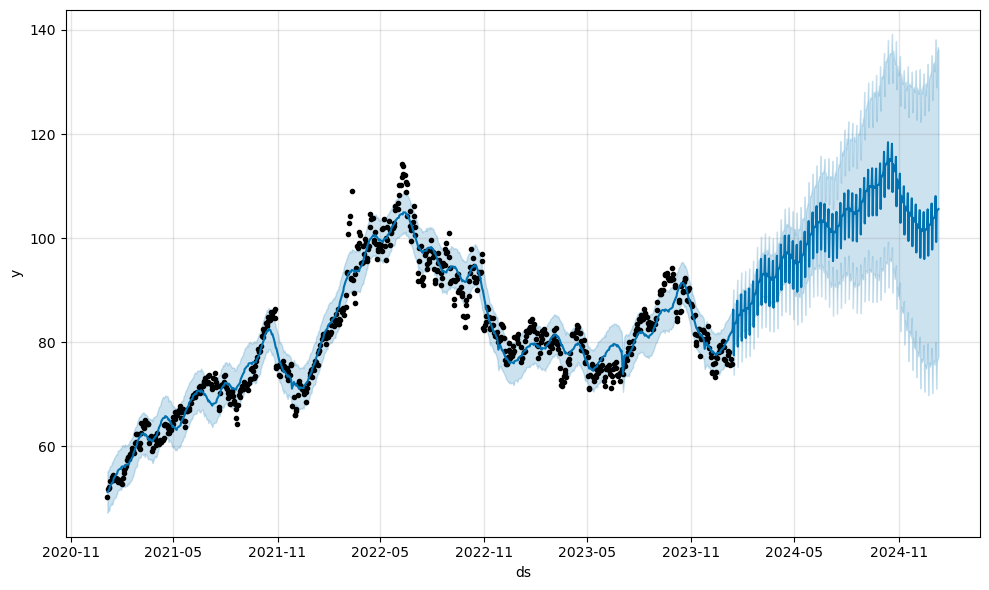

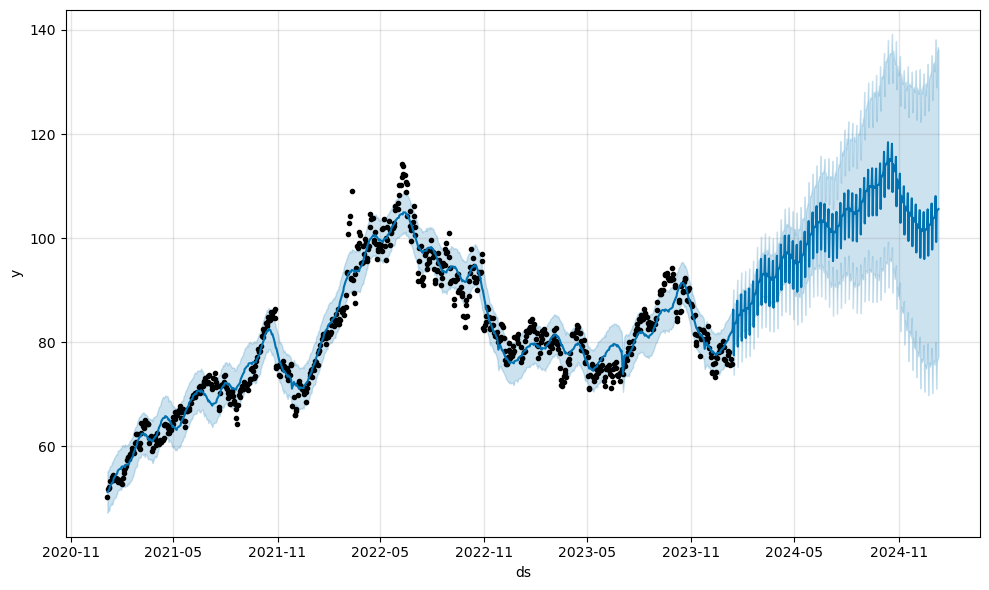

In [298]:
model.plot(forecast)